# Feature Visulization For Cifar10 
## 1. Pre-processing and Model Construction
### (1) Import Library and Define functions

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from random import randint
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
from io import BytesIO

#####  Define several functions:

In [50]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def initWeight(shape):
    
    weights = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(weights)


def initBias(shape):
    bias = tf.constant(0.1,shape=shape)
    return tf.Variable(bias)


def conv2d(x,W):
    """
    The convolution has padding of 1 on each side, and moves by 1.
    """
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")


def maxPool2d(x):
    """max pooling basically shrinks it by 2x, 
    taking the highest value on each feature.
    """
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5


def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers
    /Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

##### Data processing:

In [155]:
xs = []
ys = []
for j in range(5):
    d = unpickle('cifar-10-batches-py/data_batch_{}'.format(j+1))
    x = d[b'data']
    y = d[b'labels']
    xs.append(x)
    ys.append(y)
xs=np.array(xs).reshape(50000,3072)
ys=np.array(ys).reshape(50000)


validationData =xs[555:batchsize+555]
validationRawLabel = ys[555:batchsize+555]
validationLabel = np.zeros((batchsize,10))
validationLabel[np.arange(batchsize),validationRawLabel] = 1
validationData = validationData/255.0
validationData = np.reshape(validationData,[-1,3,32,32])
validationData = np.swapaxes(validationData,1,3)

### (2) CNN Model Construction:
Construct CNN with two convolution layers and two full connection.

In [3]:
batchsize = 50
imagesize = 32
colors = 3

sess = tf.InteractiveSession()

img = tf.placeholder("float",shape=[None,imagesize,imagesize,colors])
lbl = tf.placeholder("float",shape=[None,10])
# for each 5x5 area, check for 32 features over 3 color channels
wConv1 = initWeight([5,5,colors,32])
bConv1 = initBias([32])
# move the conv filter over the picture
conv1 = conv2d(img,wConv1)
# adds bias
bias1 = conv1 + bConv1
# relu = max(0,x), adds nonlinearality
relu1 = tf.nn.relu(bias1)
# maxpool to 16x16
pool1 = maxPool2d(relu1)
# second conv layer, takes a 16x16 with 32 layers, turns to 8x8 with 64 layers
wConv2 = initWeight([5,5,32,64])
bConv2 = initBias([64])
conv2 = conv2d(pool1,wConv2)
bias2 = conv2 + bConv2
relu2 = tf.nn.relu(bias2)
pool2 = maxPool2d(relu2)
# fully-connected is just a regular neural net: 8*8*64 for each training data
wFc1 = initWeight([int((imagesize/4) * (imagesize/4) * 64), 1024])
bFc1 = initBias([1024])
# reduce dimensions to flatten
pool2flat = tf.reshape(pool2, [-1, int((imagesize/4) * (imagesize/4) *64)])
# 128 training set by 2304 data points
fc1 = tf.matmul(pool2flat,wFc1) + bFc1;
relu3 = tf.nn.relu(fc1);
# dropout removes duplicate weights
keepProb = tf.placeholder("float");
drop = tf.nn.dropout(relu3,keepProb);
wFc2 = initWeight([1024,10]);
bFc2 = initWeight([10]);
# softmax converts individual probabilities to percentages
guesses = tf.nn.softmax(tf.matmul(drop, wFc2) + bFc2);
# how wrong it is
cross_entropy = -tf.reduce_sum(lbl*tf.log(guesses + 1e-9));
# theres a lot of tensorflow optimizers such as gradient descent
# adam is one of them
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy);
# array of bools, checking if each guess was correct
correct_prediction = tf.equal(tf.argmax(guesses,1), tf.argmax(lbl,1));
# represent the correctness as a float [1,1,0,1] -> 0.75
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"));

### (3) Train the model:

In [8]:
sess.run(tf.global_variables_initializer());
for i in range(8000+1):
    randomint = randint(0,10000 - batchsize - 1)
    trainingData = xs[randomint:batchsize+randomint]
    rawlabel = ys[randomint:batchsize+randomint]
    trainingLabel = np.zeros((batchsize,10))
    trainingLabel[np.arange(batchsize),rawlabel] = 1
    trainingData = trainingData/255.0
    trainingData = np.reshape(trainingData,[-1,3,32,32])
    trainingData = np.swapaxes(trainingData,1,3)

    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        img: validationData, lbl: validationLabel, keepProb: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

        
    optimizer.run(feed_dict={img: trainingData, lbl: trainingLabel, keepProb: 0.5})


step 0, training accuracy 0.1
step 100, training accuracy 0.36
step 200, training accuracy 0.38
step 300, training accuracy 0.42
step 400, training accuracy 0.52
step 500, training accuracy 0.56
step 600, training accuracy 0.6
step 700, training accuracy 0.54
step 800, training accuracy 0.52
step 900, training accuracy 0.62
step 1000, training accuracy 0.54
step 1100, training accuracy 0.64
step 1200, training accuracy 0.56
step 1300, training accuracy 0.56
step 1400, training accuracy 0.58
step 1500, training accuracy 0.6
step 1600, training accuracy 0.6
step 1700, training accuracy 0.58
step 1800, training accuracy 0.68
step 1900, training accuracy 0.7
step 2000, training accuracy 0.62
step 2100, training accuracy 0.7
step 2200, training accuracy 0.74
step 2300, training accuracy 0.68
step 2400, training accuracy 0.7
step 2500, training accuracy 0.72
step 2600, training accuracy 0.76
step 2700, training accuracy 0.72
step 2800, training accuracy 0.76
step 2900, training accuracy 0.72

##  2 Deconvolution Method:
### (1) Choose the most obvious image for each feature from one batch(50 images):

In [159]:
batchsizeFeatures = 50
imageIndex = 56

inputImage = xs[imageIndex:imageIndex+batchsizeFeatures]
inputImage = inputImage/255.0
inputImage = np.reshape(inputImage,[-1,3,32,32])
inputImage = np.swapaxes(inputImage,1,3)

inputLabel = np.zeros((batchsize,10))
inputLabel[np.arange(1),ys[imageIndex:imageIndex+batchsizeFeatures]] = 1;


featuresReLu1 = tf.placeholder("float",[None,32,32,32])
unReLu = tf.nn.relu(featuresReLu1)
unBias = unReLu
unConv = tf.nn.conv2d_transpose(unBias, wConv1, 
                                output_shape=[batchsizeFeatures,
                                              imagesize,imagesize,colors], 
                                strides=[1,1,1,1], padding="SAME")
activations1 = relu1.eval(feed_dict={img: inputImage, lbl: inputLabel, keepProb: 1.0})

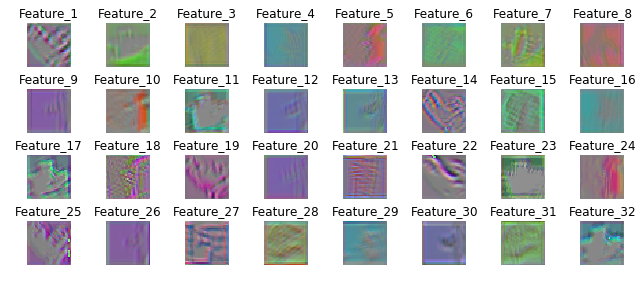

In [129]:
plt.figure(num='CNV1',figsize=(10,8))
for i in range(32):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
    
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    
    pixelactive = unConv.eval(feed_dict={featuresReLu1: isolated})
    plt.subplot(4,8,i+1)
    plt.title('Feature_{}'.format(i+1))
    plt.imshow(visstd(pixelactive[best,:,:,:]))
    plt.axis('off')
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

* **Feature Comparison: **
  1. Feature 3 and 4 almost have the same shape but different background colors. 
  2. Feature 9, 20 and 26 seem to own same background color and all emphasize the edges on the right side, but Feature 20 has more stripes than 9 and 26.
* **Feature Grouping: **
  1. It's easy to classify Feature 3, 4 and 6 as one group which has emphasize the background instead of edges. The differences between these three features are the background colors.  
  2. Feature 17, 23 and 32 seem to own some kind shape which has similiar edges but different colors. Only considering colors, Feature 3, 7 and 28 get the color yellow; 5, 8 can get red and 4, 13, 16, 29 find blue.

In [146]:
featuresReLu2 = tf.placeholder("float",[None,16,16,64])
unReLu2 = tf.nn.relu(featuresReLu2)
unBias2 = unReLu2
unConv2 = tf.nn.conv2d_transpose(unBias2, wConv2, 
                                 output_shape=[batchsizeFeatures,16,16,32] ,
                                 strides=[1,1,1,1], padding="SAME")
unPool2 = unpool(unConv2)

unReLu2 = tf.nn.relu(unPool2)
unBias2 = unReLu2
unConv2 = tf.nn.conv2d_transpose(unBias2, wConv1, 
                                 output_shape=[batchsizeFeatures,
                                               imagesize,imagesize,3], 
                                 strides=[1,1,1,1], padding="SAME")
activations2 = relu2.eval(feed_dict={img: inputImage, lbl: inputLabel, keepProb: 1.0})

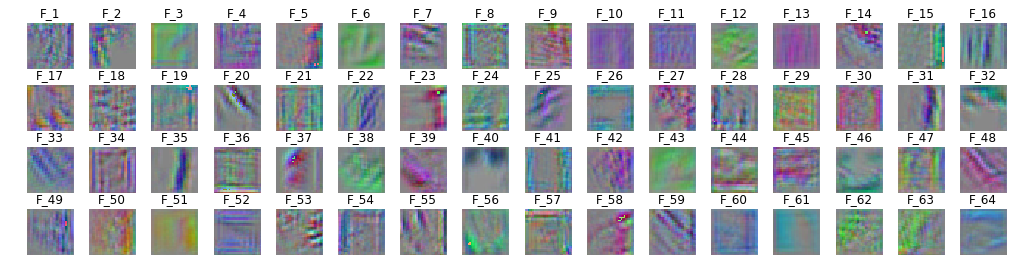

In [147]:
plt.figure(num='CNV2',figsize=(16,8))
for i in range(64):
    isolated = activations2.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
    #These two lines set all other features other than feature i to 0
    
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    
    """
    These two lines are particular for batch of images.
    That means choose one image from this batch of images which 
    feacture i can judge best.
   """
    pixelactive = unConv2.eval(feed_dict={featuresReLu2: isolated})
     
   
    plt.subplot(4,16,i+1)
    plt.title('F_{}'.format(i+1))
    plt.imshow(visstd(pixelactive[best,:,:,:]))
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

* **Feature Comparison: **
  1. Feature 32 forcus some edges on the top with some kind of green background and Feature 40 has blue on the top.
  2. Feature 26 and 52 seem to have a square inside the image. Feature 23 may tell a blue edge and 52 has severla purple edges.  
* **Feature Grouping: **
  1. All Feature 20, 48 and 59 concentrate on the stripes from left top corner to the right bottom corner.  
  2. Feature 31 and 35 get the information the right half.

### (2) Focusing on one image:
Choose one of the images, for example we choose 1st image of the training set. From the label, we know this is a image of a dog.

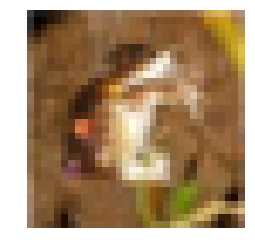

In [151]:
i_data = xs[0]
i_data = i_data/255.0
i_data = np.reshape(i_data,[-1,3,32,32])
i_data = np.swapaxes(i_data,1,3)
plt.imshow(i_data[0,:,:,:])
plt.axis('off')
plt.show()

#### Visualizing First Layer:

In [158]:
t_data_new = xs[0]
t_data_new = t_data_new/255.0
t_data_new = np.reshape(t_data_new,[-1,3,32,32])
t_data_new = np.swapaxes(t_data_new,1,3)

In [142]:
featuresReLu1 = tf.placeholder("float",[None,32,32,32])
unReLu = tf.nn.relu(featuresReLu1)
unBias = unReLu
unConv = tf.nn.conv2d_transpose(unBias, wConv1, 
                                output_shape=[1,imagesize,
                                              imagesize,colors],
                                strides=[1,1,1,1], padding="SAME")
activations1 = relu1.eval(feed_dict={img: t_data_new, keepProb: 1.0})

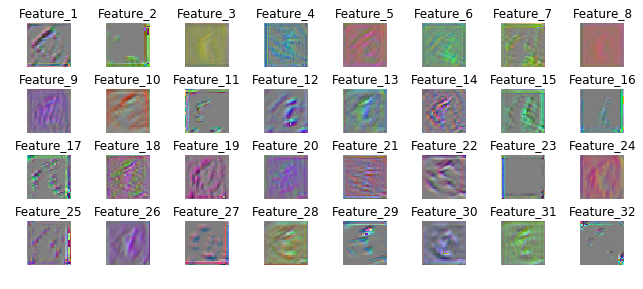

In [143]:
plt.figure(num='CNV1',figsize=(10,8))
for i in range(32):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
  
    pixelactive = unConv.eval(feed_dict={featuresReLu1: isolated})
    plt.subplot(4,8,i+1)
    plt.title('Feature_{}'.format(i+1))
    plt.imshow(visstd(pixelactive[0,:,:,:]))
    plt.axis('off')
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

When we focus on one image, some of these features can be intepret as some parts of the original image.  
* **Feature Comparison: **  
  1. Feature 28 and 30 have the same outline of the dog, but 28 with yellow and 30 with blue. Same comparison can be find between Feature 19, 24 and 26.  
  2. Feature 6 and 15 both have green background. However, Feature 15 consider more on the right side of the dog which represent the legs of the dog.  
* **Feature Grouping: **  
  1. Feature 28, 30 and 31 have the same outline of the dog with different colors. These featrures may get information of the edge.  
  2. On the contrary, each of Feature 2, 8 and 23 almost has one color image which indicate the background information.

#### Visualizing Second Layer:

In [157]:
featuresReLu2 = tf.placeholder("float",[None,16,16,64])
unReLu2 = tf.nn.relu(featuresReLu2)
unBias2 = unReLu2
unConv2 = tf.nn.conv2d_transpose(unBias2, wConv2, output_shape=[1,16,16,32] , 
                                 strides=[1,1,1,1], padding="SAME")
unPool2 = unpool(unConv2)

unReLu2 = tf.nn.relu(unPool2)
unBias2 = unReLu2
unConv2 = tf.nn.conv2d_transpose(unBias2, wConv1, 
                                 output_shape=[1,imagesize,imagesize,3] , 
                                 strides=[1,1,1,1], padding="SAME")
activations2 = relu2.eval(feed_dict={img: t_data_new, keepProb: 1.0})

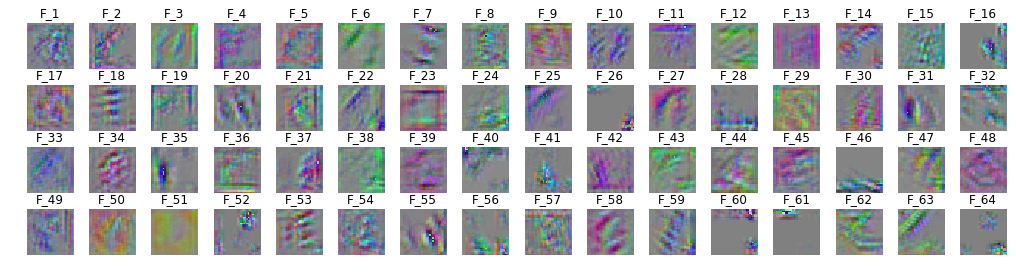

In [145]:
plt.figure(num='CNV2',figsize=(16,8))
for i in range(64):
    isolated = activations2.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
   
    pixelactive = unConv2.eval(feed_dict={featuresReLu2: isolated})
     

    plt.subplot(4,16,i+1)    
    plt.imshow(visstd(pixelactive[0,:,:,:]))
    plt.title('F_{}'.format(i+1))
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

Just as we have done on a batch of images and even we set the input as one fixed image, second layer still has a very complex feature map. It is hard to tell what information each feature want to provide. Some of the features can see a little clues related to the original image such as Feature 27 and 58. These two can see some outlines of the dog.    
* **Feature Comparison: **  
  1. Feature 11 forcus on the top purple but Feature 28 forcus on the bottom.  
  2. Feature 23 and 29 seem to have a square inside the image. Feature 23 may tell a black edge and 29 has a yellow edge.  
* **Feature Grouping: **  
  1. All Feature 6, 25 and 63 concentrate on the left top of the image.  
  2. Feature 16 and 37 get the information the right half.

## 3 Deep Dream Feature Visualization 
### (1) Visualizing First Layer：

In [148]:
def vf_layer1(nimg,nf,nit):
    """
    Define the featrue visualization of CNN 1st layer
    nimg = number of image, nf = number of featrue , nit= number of iteration
    """
    t_data = xs[nimg]
    t_data = t_data/255.0
    t_data = np.reshape(t_data,[-1,3,32,32])
    t_data = np.swapaxes(t_data,1,3)
    
    t_img = tf.placeholder("float",shape=[None,imagesize,imagesize,colors])
    t_bias1 = conv2d(t_img,wConv1) + bConv1
    t_score = tf.reduce_mean(t_bias1[:,:,:,nf]) 
    
    t_grad = tf.gradients(t_score, t_img)[0] 
    
    for i in range(nit):
        g, score = sess.run([t_grad, t_score], {t_img:t_data})
        step_size= 1/g.std()+1e-8         
        t_data+= g*step_size
    return t_data

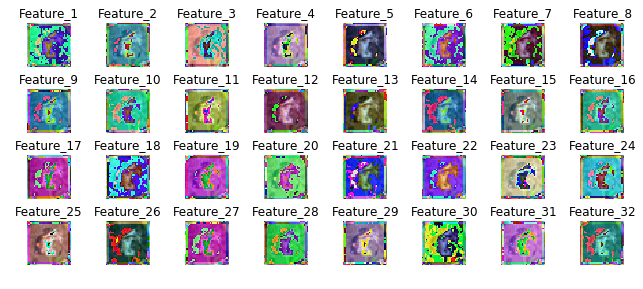

In [150]:
plt.figure(num='CNV1',figsize=(10,8))
for i in range(32):#plot all the 32 features the CNN 1st layer extracts
    plt.subplot(4,8,i+1)      
    plt.imshow(vf_layer1(0,i,20)[0,:,:,:])
    plt.title('Feature_{}'.format(i+1))
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

We can still tell the original image from all 32 features. Also we can see the differences between these features.  
* **Feature Comparison: **  
  1. Feature 19 and 27 have purple background and several green pixels in the middle. But when we look the outline(shadow) of dog, we can find the differences. In No.19 feature, the outline(shadow) shows purple which has little different from the background. On the contrary, the outline(shadow) shows green. We may have a conclusion that Feature 27 emphasizes the outline(shadow) than Feature 19.  
  2. Feature 15 and 25 both have almost the same image with different colors.  
  
* **Feature Grouping: **  
  1. Shadow detection: Feature 5, 8, 9, 10, 12, 17 and 27 find the darkness changes between the dog and the background.  
  2. Edge detection: Feature 6, 7 and 30 only have the dog and the background which means no emphasis on the shadow. 

### (2)  Visualizing Second Layer:

In [152]:
def vf_layer2(nimg,nf,nit):
    
    """
    Define the featrue visualization of CNN 2nd layer 
    nimg = number of image, nf = number of featrue , nit= number of iteration
    """
   
    t_data_new = xs[nimg]
    t_data_new = t_data_new/255.0
    t_data_new = np.reshape(t_data_new,[-1,3,32,32])
    t_data_new = np.swapaxes(t_data_new,1,3)
    t_img_new = tf.placeholder("float",shape=[None,imagesize,imagesize,colors])
    
    
    t_bias1 = conv2d(t_img_new,wConv1) + bConv1
    t_relu1 = tf.nn.relu(t_bias1)
    # maxpool to 16x16
    t_pool1 = maxPool2d(t_relu1)
    # second conv layer, takes a 16x16 with 32 layers, turns to 8x8 with 64 layers
    t_bias2 = conv2d(t_pool1,wConv2) + bConv2
    
    
    
    
    t_score_new = tf.reduce_mean(t_bias2[:,:,:,nf]) 
    t_grad_new = tf.gradients(t_score_new, t_img_new)[0] 
    
    
    
    for i in range(nit):
        g_new, score_new = sess.run([t_grad_new, t_score_new], {t_img_new:t_data_new})
        step_size= 1/g_new.std()+1e-8         
        t_data_new+= g_new*step_size
    return t_data_new

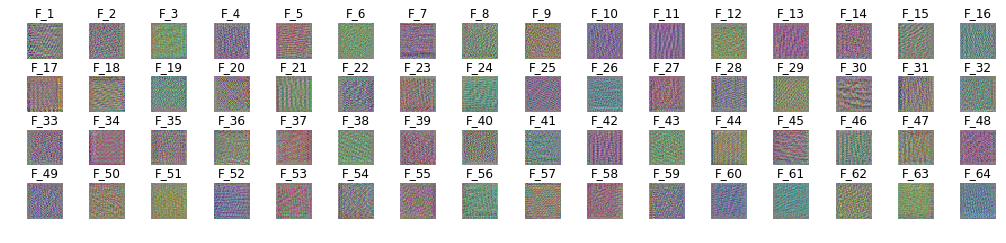

In [154]:
plt.figure(num='CNV2',figsize=(16,16))
for i in range(64):#plot all the 64 features the CNN 2nd layer extracts
    plt.subplot(4,16,i+1)      
    plt.imshow(visstd(vf_layer2(0,i,30)[0,:,:,:]))
    plt.title('F_{}'.format(i+1))
    plt.axis('off') 
plt.subplots_adjust(top=0.25, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

When things come to the second layer, all features showed above seem to have some kinds of patterns. Comparing with the first layer, we cannot tell the original image from these plots. These features may give some information to help the neural network recognize which class the original image belongs to.  
* **Feature Grouping: **  
   1. Feature 5, 7, 17 and 45 show some horizontal stripes and at the same time 13, 23, 31 and 42 show some vertical stripes.  
   2. Feature 6, 38, 43 and 36 extract color green and 10, 11, 42, 48 find color purple.